# Building an ARIMA Model for a Financial Dataset

In this notebook, you will build an ARIMA model for AAPL stock closing prices. The lab objectives are:

* Pull data from Google Cloud Storage into a Pandas dataframe
* Learn how to prepare raw stock closing data for an ARIMA model
* Apply the Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

In [ ]:
%pip install --user statsmodels

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Clod Storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [3]:
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [45]:
df_week = df.resample('w').mean() # TODO: Use the df DataFrame to resample the 'close' column to a weekly granularity. Use the mean as the aggregator. 
df_week = df_week[['close']]
df_week.head()

,close,close_lag2
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,NaN
2009-06-21,19.525140,20.44570
2009-06-28,19.711440,20.10686
2009-07-05,20.258925,19.52514


Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [20]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,-0.016712
2009-06-21,19.525140,-0.029358
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396


In [24]:
df_week.tail()

,close,weekly_ret
date,,
2019-05-12,202.428,-0.023976
2019-05-19,188.876,-0.069294
2019-05-26,182.220,-0.035876
2019-06-02,177.245,-0.027682
2019-06-09,173.300,-0.022509


In [21]:
# drop null rows
df_week.dropna(inplace=True)

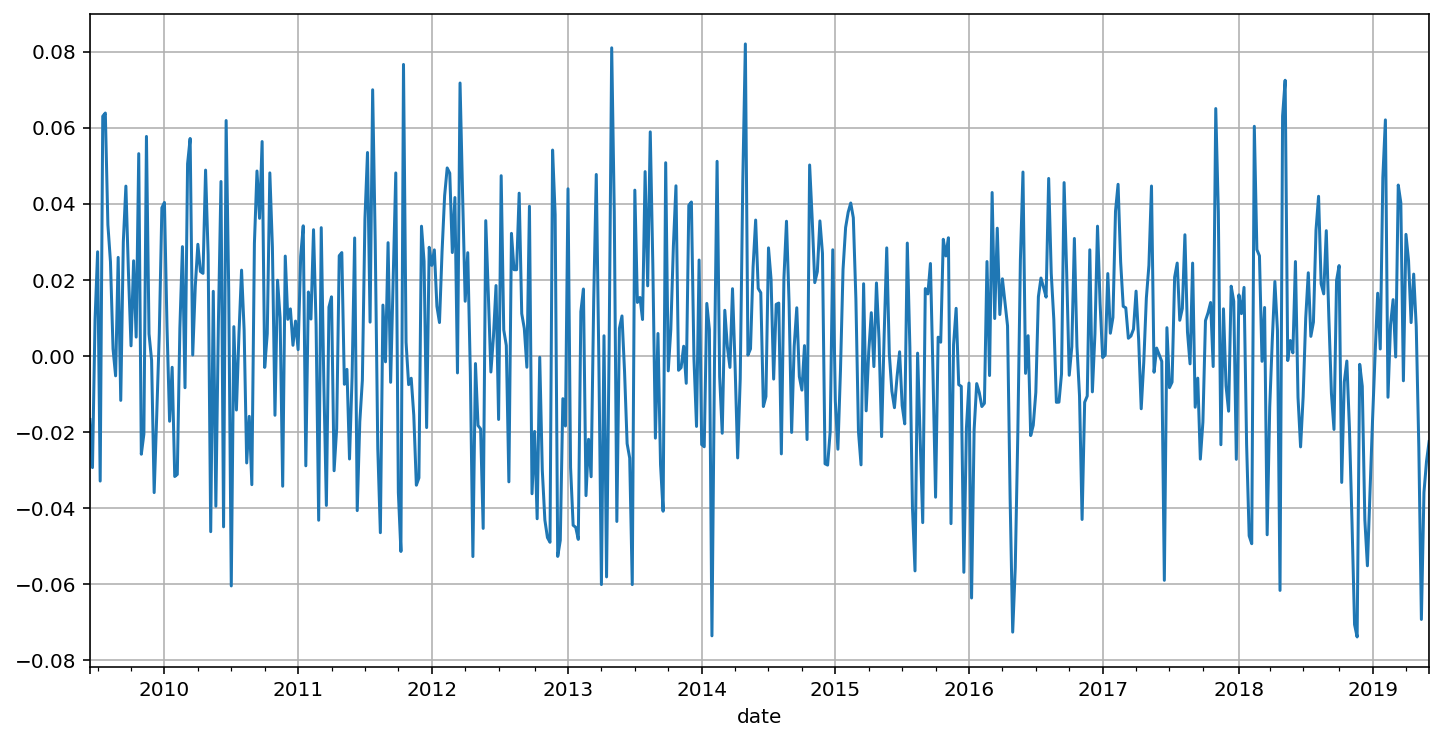

In [29]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));
plt.grid(True)

In [30]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [31]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [32]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

In [36]:
rolmean[25:35]

,weekly_ret
date,
2009-12-06,0.014822
2009-12-13,0.010849
2009-12-20,0.009420
2009-12-27,0.010132
2010-01-03,0.012056
2010-01-10,0.012699
2010-01-17,0.010544
2010-01-24,0.010980
2010-01-31,0.007895


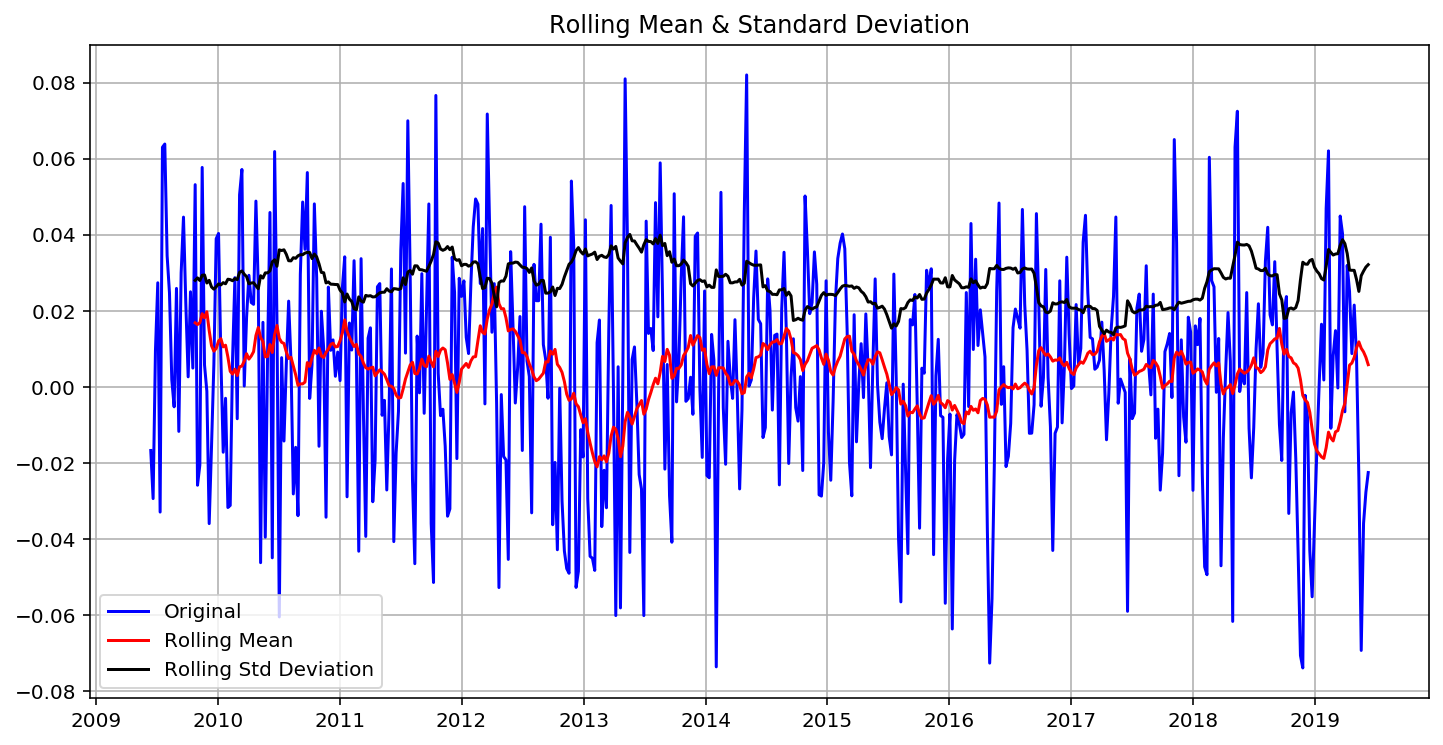

In [34]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.legend(loc='best')
plt.show(block=False)

In [46]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

In [55]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

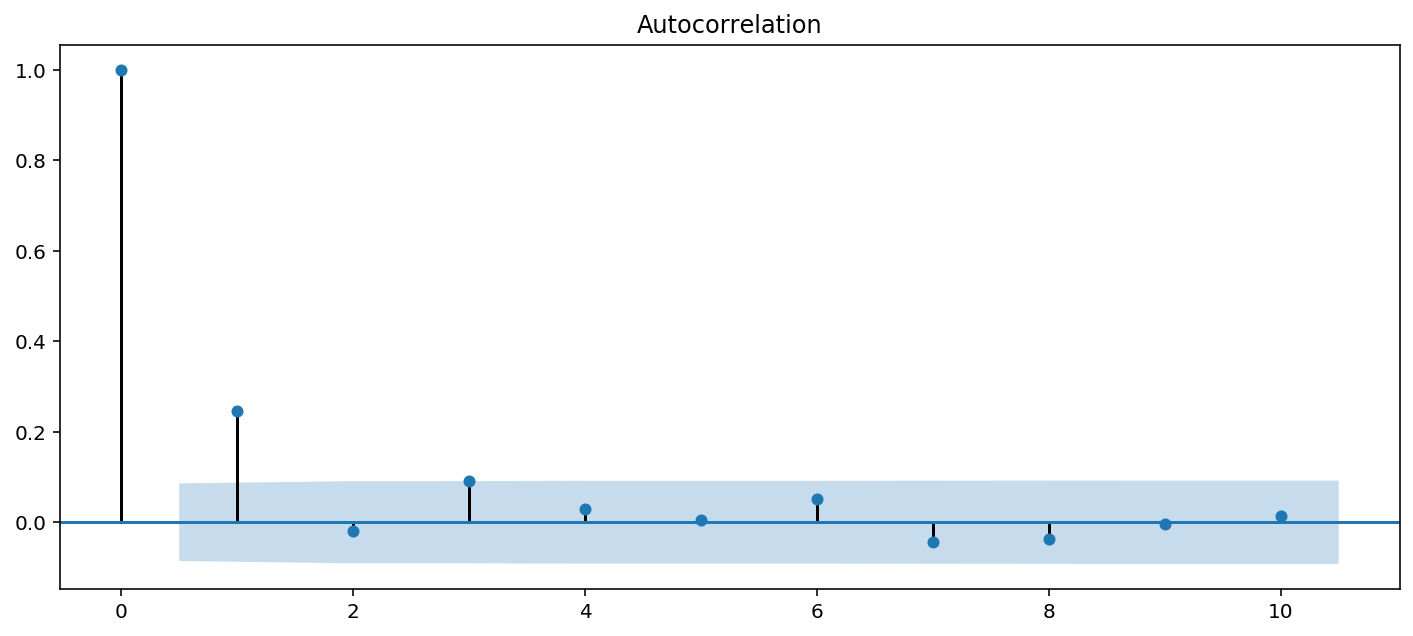

In [56]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

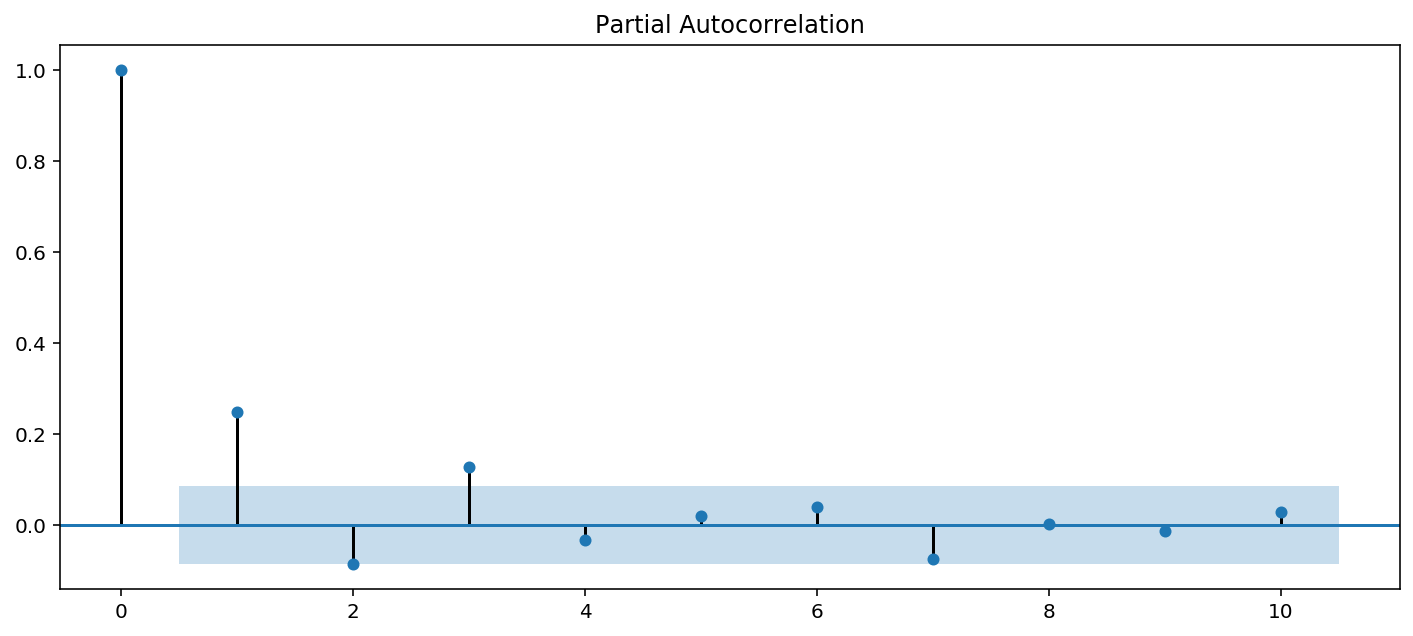

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="../imgs/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [67]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (3, 1)).fit() # TODO: Fit an ARMA model to the differenced data
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                     ARMA(3, 1)   Log Likelihood                1131.581
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 12 Jan 2020   AIC                          -2251.163
Time:                        21:04:09   BIC                          -2225.617
Sample:                             0   HQIC                         -2241.157
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.442      0.015       0.001       0.007
ar.L1.y        0.0601      0.264      0.227      0.820      -0.458       0.578
ar.L2.y       -0.0591      0.084     -0.705      0.481      -0.223       0.105
ar.L3.y        0.1080      0.053      2.049      0.041       0.005       0.211
ma.L1.y        0.2219      0.265      0.839      0.402      -0.297       0.740
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8278           -1.8757j            2.0502           -0.3161
AR.2           -0.8278           +1.8757j            2.0502            0.3161
AR.3            2.2031           -0.0000j            2.2031           -0.0000
MA.1           -4.5055           +0.0000j            4.5055            0.5000
-----------------------------------------------------------------------------
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

In [ ]:
# TODO: Plot the ARMA fitted values on the same plot as the differenced time series

Let's make a forecast 2 weeks ahead:

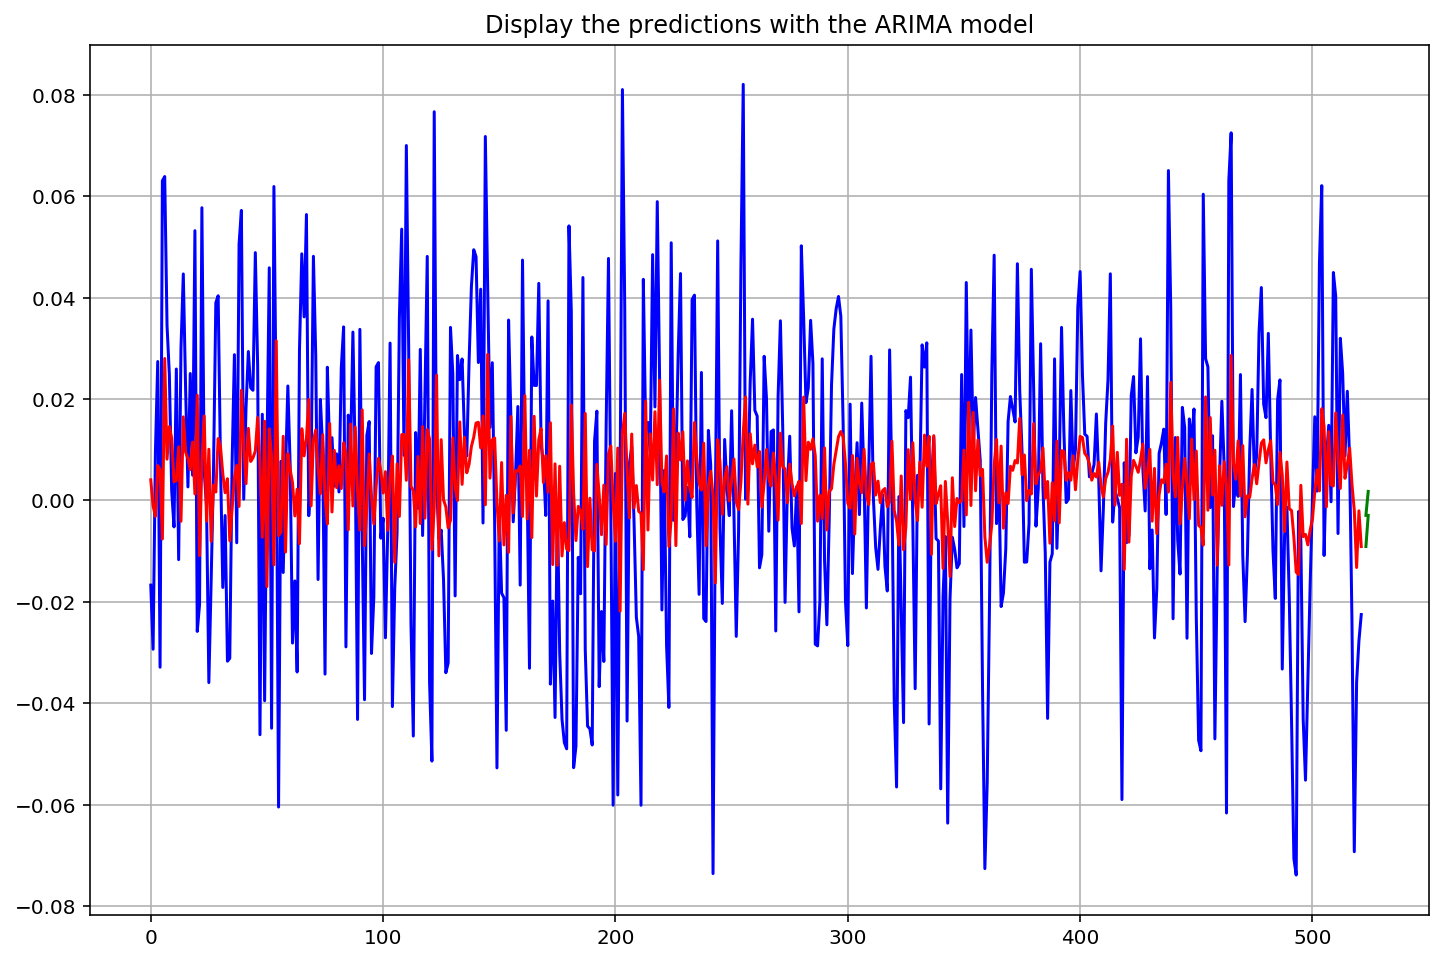

In [64]:
steps = 2

forecast = ar1.forecast(steps=steps)[0] # TODO: Use the ARMA model to create a forecast two weeks into the future

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.grid(True)
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.